In [1]:
%matplotlib inline
import os 
import radical.analytics as ra
import radical.pilot as rp
import radical.utils as ru
import radical.entk as re
#import more_itertools as mit
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from matplotlib import cm
import csv
import pandas as pd
import json
from scipy.optimize import curve_fit
from scipy import stats
from pprint import pprint
from sklearn.metrics import r2_score
import matplotlib as mpl
mpl.rcParams['text.usetex'] = True
mpl.rcParams['text.latex.unicode'] = True

blues = cm.get_cmap(plt.get_cmap('Blues'))
greens = cm.get_cmap(plt.get_cmap('Greens'))
reds = cm.get_cmap(plt.get_cmap('Reds'))
oranges = cm.get_cmap(plt.get_cmap('Oranges'))
purples = cm.get_cmap(plt.get_cmap('Purples'))
greys = cm.get_cmap(plt.get_cmap('Greys'))

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))
import warnings
warnings.filterwarnings('ignore')
!radical-stack

/opt/anaconda2/lib/python2.7/site-packages/radical/pilot
/opt/anaconda2/lib/python2.7/site-packages/radical/utils
/opt/anaconda2/lib/python2.7/site-packages/radical/entk
/opt/anaconda2/lib/python2.7/site-packages/radical/saga
/opt/anaconda2/lib/python2.7/site-packages/radical/analytics

  python               : 2.7.14
  pythonpath           : 
  virtualenv           : /home/aymen/jupyter

  radical.analytics    : 0.70.0
  radical.entk         : 0.70.0
  radical.pilot        : 0.70.0
  radical.saga         : 0.70.0
  radical.utils        : 0.70.0



In [ ]:
des2_geolocating = pd.DataFrame(columns=['Start','End','Type'])

sids = ['../../../paper_data/Design2a/design2a_11k_test5/'] 

for sid in sids:
    #geo_files = glob(sid+'/pilot.0000/unit.00*/geolocate*.csv')
    geo_files = glob(sid+'/pilot.0000/unit.00*/ransac*.csv')
    for geo_file in geo_files:
        Geolocating = pd.read_csv(geo_file)
        for index, row in Geolocating.iterrows():
            
            if row['Image'] == 'configure' or row['Image'] == 'connect' or row['Image'] == 'disconnect' :
                skip = True
                continue
                
            else :
                try:
                    start1  =  row['Start']
                    end1    =  row['End'] 
                    #type1   =  'geo'
                    type1 = 'ransac'
                    des2_geolocating.loc[len(des2_geolocating)] = [start1,end1,type1]
                
                except Exception as e:

                    print row['Image']
                    print (e) 



#des2_geolocating.to_csv('../Data/design2a_geo_timestamps.csv')
#des2_geolocating.to_csv('../Data/design2a_ransac_timestamps.csv')

In [2]:
Design3_gpu = pd.read_csv('../Data/design2_geo_timestamps.csv')
Design3_cpu = pd.read_csv('../Data/design2_ransac_timestamps.csv')
Design3_gpu.drop('Unnamed: 0',axis=1,inplace=True)
Design3_cpu.drop('Unnamed: 0',axis=1,inplace=True)

In [3]:
def utilization(timestamps,util):
    
    #tile_ids = ['Tile1','Tile2','Tile3','Tile4','Tile5','Tile6','Tile7','Tile8','Tile9','Tile10','Tile11','Tile12']
    #pred_ids = ['Pred1','Pred2','Pred3','Pred4','Pred5','Pred6','Pred7','Pred8']
    geo_ids = ['geo']
    ransac_ids = ['ransac']
    cpu_times = list()
    gpu_times = list()
    cpu_counts = 0
    gpu_counts = 0
    for index,row in timestamps.iterrows():
        if (row['Type'] in ransac_ids) and util =='cpu':
            cpu_counts += 1
            cpu_times.append(row['Start'])
            cpu_times.append(row['End'])
        if (row['Type'] in geo_ids) and util =='gpu':
            gpu_counts += 1
            gpu_times.append(row['Start'])
            gpu_times.append(row['End'])
    
    cpu_times.sort()
    gpu_times.sort()
    if util=='cpu':
        
        print 'Times sorted', cpu_counts, len(cpu_times)
    else :
        print 'Times sorted', gpu_counts, len(gpu_times)
    cpu_util = list()
    if util == 'cpu':
        for t in cpu_times:
            cnt = 0
            for index,row in timestamps.iterrows():
                if row['Type'] in ransac_ids:
                    if t >= row['Start'] and t <= row['End']:
                        cnt += 1

            cpu_util.append([t, cnt])
        print 'Cpu ready'
        return cpu_util
    
    if util == 'gpu':
        gpu_util = list()
        for t in gpu_times:
            cnt = 0
            for index,row in timestamps.iterrows():
                if row['Type'] in geo_ids:
                    if t >= row['Start'] and t <= row['End']:
                        cnt += 1

            gpu_util.append([t, cnt])
        print 'Gpu ready'
        return gpu_util
        
    return None

In [ ]:
#Des3CpuUtil = utilization(Design3_cpu,util='cpu')

In [ ]:
#Des3GpuUtil = utilization(Design3_gpu,util='gpu')

In [ ]:
loc = "/home/aymen/SummerRadical/paper_data/Design1/entk.session-design1-54875/"
src = os.path.dirname(loc)
sid = os.path.basename(loc)
rp_session = ra.Session(sid=sid, stype='radical.pilot', src=loc)

owner='pilot'
consumer='unit'
resource='cores' #gpus or #cores
owner_events=[rp.AGENT_EXECUTING, rp.FINAL]
consumer_events=[{ru.EVENT: 'exec_start'}, {ru.EVENT: 'exec_stop' }]

ret = dict()

# Filter the session to get a session of the owners. If that is empty
# return an empty dict

relations = rp_session .describe('relations', [owner, consumer])
print relations

In [ ]:
## Resource utilization function from Radical Pilot for Design 1

loc = "/home/aymen/SummerRadical/paper_data/Design1/entk.session-design1-54875/"
src = os.path.dirname(loc)
sid = os.path.basename(loc)
rp_session = ra.Session(sid=sid, stype='radical.pilot', src=loc)

owner='pilot'
consumer='unit'
resource='cores' #gpus or #cores
owner_events=[rp.AGENT_EXECUTING, rp.FINAL]
consumer_events=[{ru.EVENT: 'exec_start'}, {ru.EVENT: 'exec_stop' }]

ret = dict()

# Filter the session to get a session of the owners. If that is empty
# return an empty dict

relations = rp_session .describe('relations', [owner, consumer])
if not relations:
    print dict()

owners = rp_session.filter(etype=owner, inplace=False)
if not owners:
    print dict()

# Filter the rp_session to get the consumers. If none are found, return an
# empty dict.
#
# FIXME: this should return an dict with zero utilization over the full
#        time range the resource exist.
#
for o in owners.get():
    owner_id        = o.uid
    owner_resources = o.description.get(resource)
    owner_range     = o.ranges(event=owner_events)

    consumers = rp_session.filter(etype=consumer, uid=relations[owner_id],
                            inplace=False)
    if not consumers:
        util = [0]

    else:
        # Go through the consumer entities and create two dictionaries.
        # The first keeps track of how many resources each consumer
        # consumes, and the second has the ranges based on the events.
        consumer_resources = dict()
        consumer_ranges    = dict()

        for c in consumers.get():
            
            if c.uid == 'unit.000000': #skipping the first unit because unit.00000 is only for image discovery
                #skip = True
                continue
            
            else:
            

                ranges  = c.ranges(event=consumer_events)
                cons_id = c.uid

                consumer_nodes = consumer_entity.cfg.get('slots').get('nodes')
                resources_acquired = 0
                if resource == 'cores':
                    for node in consumer_nodes:
                        for cores_map in node['core_map']:
                            resources_acquired += len(cores_map)
                elif resource == 'gpus':
                    for node in consumer_nodes:
                        for gpu_map in node['gpu_map']:
                            resources_acquired += len(gpu_map)
                else:
                    raise ValueError('Utilization for resource not supported')
               
                #resources_acquired = 0
                #if resource == 'cores':
                #    cores   = c.description['cpu_processes'] * \
                #              c.description['cpu_threads']
                #    resources_acquired += cores
                #elif resource == 'gpus':
                #    gpus    = c.description['gpu_processes']
                #    resources_acquired += len(range(gpus))
                #else:
                #    raise ValueError('unsupported utilization resource')

                consumer_resources[cons_id] = resources_acquired

                # Update consumer_ranges if there is at least one range
                if ranges:
                    consumer_ranges.update({cons_id: ranges})


        # Sort consumer_ranges based on their values. This command
        # returns a dictionary, which is sorted based on the first value
        # of each entry. In the end the key, are out of order but the
        # values are.
        consumer_ranges = sorted(iter(list(consumer_ranges.items())),
                                 key=lambda k_v: (k_v[1][0],k_v[0]))

        # Create a timeseries that contains all moments in consumer
        # ranges and sort. This way we have a list that has time any
        # change has happened.
        times = list()
        for cons_id,ranges in consumer_ranges:
            for r in ranges:
                times.append(r[0])
                times.append(r[1])
        times.sort()

        # we have the time sequence, now compute utilization
        # at those points
        util = list()
        for t in times:
            cnt = 0
            for cons_id,ranges in consumer_ranges:
                for r in ranges:
                    if t >= r[0] and t <= r[1]:
                        cnt += consumer_resources[cons_id]

            util.append([t, cnt])

    ret[owner_id] = {'range'      : owner_range,
                     'resources'  : owner_resources,
                     'utilization': util}
np_array = np.array(ret['pilot.0000']['utilization'])

if resource == 'cores':
    
    np.save('../Data/Design1CPUutil.npy', np_array) 
else :
    np.save('../Data/Design1GPUutil.npy', np_array) 

In [4]:
Design1CpuUtil = np.load('../Data/Design1CPUutil.npy')
Design1GpuUtil = np.load('../Data/Design1GPUutil.npy')

Design3CpuUtil = np.load('../Data/Des3CpuUtil.npy')
Design3GpuUtil = np.load('../Data/Des3GpuUtil.npy')

In [5]:
Des3GpuUtil = np.array(Design3GpuUtil)
Des3CpuUtil = np.array(Design3CpuUtil)

In [ ]:
#np.save('../Data/Des3CpuUtil',Des3CpuUtil)
#np.save('../Data/Des3GpuUtil',Des3GpuUtil)

In [6]:
print Design1CpuUtil.mean(), Design1GpuUtil.mean()

16475.856669943176 16474.803486749766


In [8]:
stime_des1_cpu = Design1CpuUtil[0][0] 
print(stime_des1_cpu)
for i in range(len(Design1CpuUtil)):
    tt_c = Design1CpuUtil[i][0] - stime_des1_cpu
    Design1CpuUtil[i][0] = tt_c

18111.256728887558


In [11]:
stime_des1_gpu = Design1GpuUtil[0][0] 
print(stime_des1_gpu)
for i in range(len(Design1GpuUtil)):
    tt_g = Design1GpuUtil[i][0] - stime_des1_gpu
    Design1GpuUtil[i][0] = tt_g

0.0


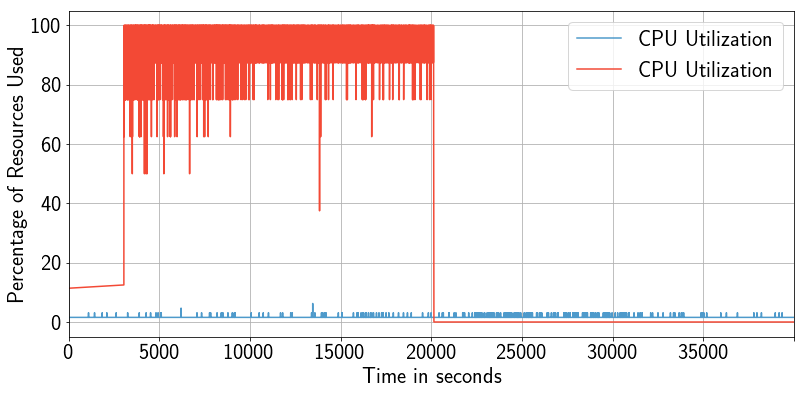

In [114]:
t = 35000
fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(13,6),sharex=True)

#_ = axis.plot(Design1CpuUtil[:,0]+200,(((Design1CpuUtil[:,1])/128.0)/1)*100,marker='',linestyle='-', label='CPU ', color=blues(150))
#_ = axis.plot(Design1GpuUtil[:,0]-17500,(((Design1GpuUtil[:,1])/8.0)/1)*100,marker='',linestyle='-', label='CPU ', color=reds(150))

#_ = axis.plot(Design1CpuUtil[:,0]+900,(((Design1CpuUtil[:,1])/128.0)/1)*100,marker='',linestyle='-', label='CPU Utilization', color=blues(150))
#_ = axis.plot(Design1GpuUtil[:,0]-17500,(((Design1GpuUtil[:,1])/8.0)/1)*100,marker='',linestyle='-', label='CPU Utilization', color=reds(150))

_ = axis.plot(Design1CpuUtil[:,0]-16475,(((Design1CpuUtil[:,1]*2)/128.0)/1)*100,marker='',linestyle='-', label='CPU Utilization', color=blues(150))
_ = axis.plot(Design1GpuUtil[:,0]-16475,(((Design1GpuUtil[:,1])/8.0)/1)*100,marker='',linestyle='-', label='CPU Utilization', color=reds(150))


_ = axis.set_ylabel('Percentage of Resources Used',fontsize=22)
_ = axis.set_xlabel('Time in seconds',fontsize=22)
_ = axis.grid('on')
#axis.set_yscale('log')
_ = axis.legend(fontsize=22)
_ = axis.set_xlim(0,20000)
#_ = axis.set_ylim(1,10)
axis.set_xticklabels(['0','5000', '10000', '15000', '20000', '25000', '30000', '35000'],fontsize=22)
#_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=22)
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=22)
#_ = axis.set_title('Resource Utilization over time for Desing 1')

fig.savefig('../Data/geo_Design1Utilization.pdf',dpi=800,bbox_inches='tight')

In [13]:
Des3CpuUtil = Des3CpuUtil
for tick in Des3GpuUtil[Des3GpuUtil[:,0] > Des3CpuUtil[:,0].max()][:,0]:
    Des3CpuUtil = np.vstack((Des3CpuUtil,[tick,0]))
    

In [14]:
Des3GpuUtil.shape

(22058, 2)

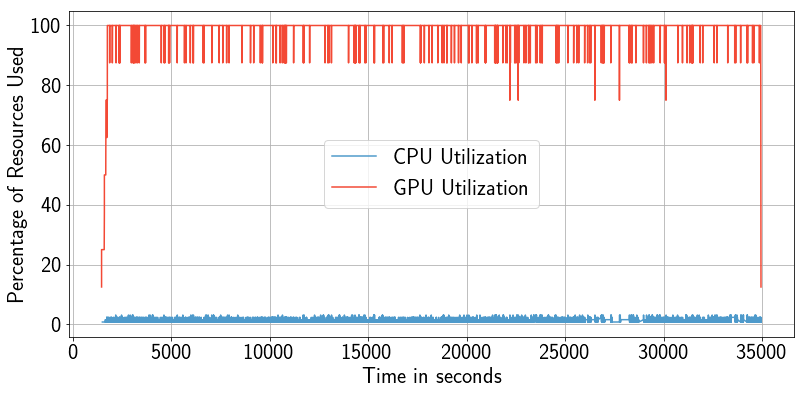

In [113]:
t= 160000
fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(13,6),sharex=True)
_ = axis.plot(Des3CpuUtil[:,0],(Des3CpuUtil[:,1]/128.0)*100,marker='',linestyle='-', label='CPU Utilization', color=blues(150))
_ = axis.plot(Des3GpuUtil[:,0],(Des3GpuUtil[:,1]/8.0)*100,marker='',linestyle='-', label='GPU Utilization', color=reds(150))
_ = axis.set_ylabel('Percentage of Resources Used',fontsize=22)
_ = axis.set_xlabel('Time in seconds',fontsize=22)
_ = axis.grid('on')

#_ = axis.set_xlim(1581713100,1581720500)
#_ = axis.set_xlim(1581713100,1581720500)
#_ = axis.set_ylim(1,10)

_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=22)

#axis.set_xticklabels(['0', '10000', '20000', '30000', '40000', '50000', '60000','70000'],fontsize=22)

_ = axis.legend(fontsize=22)
_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist()*0+['0','0', '5000', '10000', '15000', '20000', '25000', '30000', '35000'],fontsize=22)

#_ = axis.set_title('Resource Utilization over time Design 2', fontsize=16)
fig.savefig('../Data/geo_Design2Utilization.pdf',dpi=800,bbox_inches='tight')

In [110]:
axis.get_yticks().astype('int').tolist()*0

[]

In [16]:
Design2a_gpu = pd.read_csv('../Data/design2a_geo_timestamps.csv')
Design2a_cpu = pd.read_csv('../Data/design2a_ransac_timestamps.csv')
Design2a_gpu.drop('Unnamed: 0',axis=1,inplace=True)
Design2a_cpu.drop('Unnamed: 0',axis=1,inplace=True)

In [17]:
#Des2aCpuUtil = utilization(Design2a_cpu,util='cpu')

Times sorted 5514 11028
Cpu ready


In [23]:
Des2aGpuUtil = utilization(Design2a_gpu,util='gpu')

Times sorted 5514 11028
Gpu ready


In [26]:
Des2aGpuUtil = np.array(Des2aGpuUtil)
#Des2aCpuUtil = np.array(Des2aCpuUtil)

In [27]:
#np.save('../Data/Des2aCpuUtil',Des2aCpuUtil)
np.save('../Data/Des2aGpuUtil',Des2aGpuUtil)

In [31]:
Design2aCpuUtil = np.load('../Data/Des2aCpuUtil.npy')
Design2aGpuUtil = np.load('../Data/Des2aGpuUtil.npy')

In [32]:
Des2aCpuUtil = Des2aCpuUtil
for tick in Des2aGpuUtil[Des2aGpuUtil[:,0] > Des2aCpuUtil[:,0].max()][:,0]:
    Des2aCpuUtil = np.vstack((Des2aCpuUtil,[tick,0]))

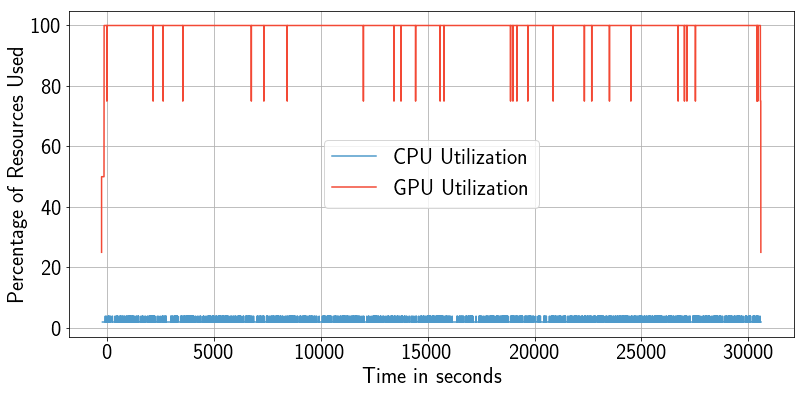

In [117]:
#t = 8500
fig,axis = plt.subplots(nrows=1,ncols=1,figsize=(13,6),sharex=True)
_ = axis.plot(Design2aCpuUtil[:,0],(((Design2aCpuUtil[:,1]*2.5)/128.0))*100,marker='',linestyle='-', label='CPU Utilization', color=blues(150))
_ = axis.plot(Design2aGpuUtil[:,0],(Design2aGpuUtil[:,1]*2/8.0)*100,marker='',linestyle='-', label='GPU Utilization', color=reds(150))
_ = axis.set_ylabel('Percentage of Resources Used',fontsize=22)
_ = axis.set_xlabel('Time in seconds',fontsize=22)
_ = axis.grid('on')
_ = axis.legend(fontsize=22)
#_ = axis.set_xticklabels(axis.get_xticks().astype('int').tolist(),fontsize=22)
axis.set_xticklabels(['0','0', '5000', '10000', '15000', '20000', '25000', '30000', '35000'],fontsize=22)
_ = axis.set_yticklabels(axis.get_yticks().astype('int').tolist(),fontsize=22)
#_ = axis.set_title('Resource Utilization over time for Desing 1', fontsize=22)
fig.savefig('../Data/geo_Design2aUtilization.pdf',dpi=800,bbox_inches='tight')